# Music Genre Classification
Machine learning project for classifying music genres using multiple approaches including tabular features and deep learning models.


## Import Libraries
Import all necessary libraries for data processing, machine learning, and deep learning.


In [3]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import warnings
warnings.filterwarnings('ignore')


## Load and Explore Dataset
Load audio files from the GTZAN dataset and organize them by genre for processing.


In [4]:
data_path = 'gtzan_dataset/genres_original'
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
audio_files = []
labels = []

for genre in genres:
    genre_path = os.path.join(data_path, genre)
    if os.path.exists(genre_path):
        print(f"Found {genre} directory with {len(os.listdir(genre_path))} files")
        for file in os.listdir(genre_path):
            if file.endswith('.wav'):
                audio_files.append(os.path.join(genre_path, file))
                labels.append(genre)
    else:
        print(f"Error: {genre_path} does not exist")

print(f"Total audio files: {len(audio_files)}")
print(f"Genres: {genres}")
print(f"Files per genre: {len(audio_files) // len(genres) if audio_files else 0}")


Found blues directory with 100 files
Found classical directory with 100 files
Found country directory with 100 files
Found disco directory with 100 files
Found hiphop directory with 100 files
Found jazz directory with 100 files
Found metal directory with 100 files
Found pop directory with 100 files
Found reggae directory with 100 files
Found rock directory with 100 files
Total audio files: 1000
Genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Files per genre: 100


## Extract MFCC Features
Define function to extract audio features including MFCC, chroma, mel, contrast, and tonnetz.


In [5]:
def extract_features(file_path, mfcc=True, chroma=True, mel=True, contrast=True, tonnetz=True):
    try:
        X, sample_rate = librosa.load(file_path, res_type='kaiser_fast', duration=30)
        stft = np.abs(librosa.stft(X))
        result = np.array([])
        
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        
        if chroma:
            try:
                chroma_feat = np.mean(librosa.feature.chroma(S=stft, sr=sample_rate).T, axis=0)
                result = np.hstack((result, chroma_feat))
            except:
                chroma_feat = np.zeros(12)
                result = np.hstack((result, chroma_feat))
        
        if mel:
            mel_feat = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
            result = np.hstack((result, mel_feat))
        
        if contrast:
            try:
                contrast_feat = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)
                result = np.hstack((result, contrast_feat))
            except:
                contrast_feat = np.zeros(7)
                result = np.hstack((result, contrast_feat))
        
        if tonnetz:
            try:
                tonnetz_feat = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T, axis=0)
                result = np.hstack((result, tonnetz_feat))
            except:
                tonnetz_feat = np.zeros(6)
                result = np.hstack((result, tonnetz_feat))
        
        return result
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


## Process Audio Files for Tabular Data
Extract features from audio files with balanced sampling across all genres.


In [6]:
features = []
processed_labels = []

if len(audio_files) == 0:
    print(" No audio files found")
else:
    print(f" Found {len(audio_files)} audio files.")
    
    files_per_genre = 10
    total_files_to_process = len(genres) * files_per_genre
    
    print(f"Processing {files_per_genre} files per genre ({total_files_to_process} total)...")
    
    genre_files = {genre: [] for genre in genres}
    for file_path, label in zip(audio_files, labels):
        genre_files[label].append(file_path)
    
    processed_count = 0
    for genre in genres:
        print(f"🎵 Processing {genre} files...")
        genre_file_list = genre_files[genre][:files_per_genre]
        
        for file_path in genre_file_list:
            try:
                feature = extract_features(file_path)
                if feature is not None:
                    features.append(feature)
                    processed_labels.append(genre)
                    processed_count += 1
                    if processed_count % 20 == 0:
                        print(f"🎵 Processed {processed_count} files")
            except Exception as e:
                print(f" Error processing {file_path}: {e}")

    features_df = pd.DataFrame(features)
    features_df['genre'] = processed_labels
    print(f" Features shape: {features_df.shape}")
    
    genre_counts = features_df['genre'].value_counts()
    print(f" Genre distribution:")
    for genre, count in genre_counts.items():
        print(f"  {genre}: {count} files")
    
    if len(features) == 0:
        print(" No features extracted!")
    else:
        print(f" Successfully extracted features from {len(features)} audio files")


 Found 1000 audio files.
Processing 10 files per genre (100 total)...
🎵 Processing blues files...
🎵 Processing classical files...
🎵 Processed 20 files
🎵 Processing country files...
🎵 Processing disco files...
🎵 Processed 40 files
🎵 Processing hiphop files...
🎵 Processing jazz files...
🎵 Processed 60 files
🎵 Processing metal files...
🎵 Processing pop files...
🎵 Processed 80 files
🎵 Processing reggae files...
🎵 Processing rock files...
🎵 Processed 100 files
 Features shape: (100, 194)
 Genre distribution:
  blues: 10 files
  classical: 10 files
  country: 10 files
  disco: 10 files
  hiphop: 10 files
  jazz: 10 files
  metal: 10 files
  pop: 10 files
  reggae: 10 files
  rock: 10 files
 Successfully extracted features from 100 audio files


## Tabular Data Classification
Prepare extracted features for machine learning by encoding labels and splitting data.


In [7]:
if 'features_df' not in locals() or len(features_df) == 0:
    print(" No features available!")
else:
    X_tabular = features_df.drop('genre', axis=1)
    y_tabular = features_df['genre']

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y_tabular)

    X_train, X_test, y_train, y_test = train_test_split(X_tabular, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print(f"Training set shape: {X_train_scaled.shape}")
    print(f"Test set shape: {X_test_scaled.shape}")
    print(f"Number of genres: {len(label_encoder.classes_)}")
    print(f"Genres: {list(label_encoder.classes_)}")


Training set shape: (80, 193)
Test set shape: (20, 193)
Number of genres: 10
Genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


## Random Forest Classifier
Train Random Forest classifier on extracted audio features for genre classification.


In [8]:
if 'X_train_scaled' not in locals():
    print(" No training data available!")
else:
    print("Training Random Forest Classifier...")
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train_scaled, y_train)
    rf_predictions = rf_model.predict(X_test_scaled)
    rf_accuracy = accuracy_score(y_test, rf_predictions)

    print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
    print("\n Classification Report:")
    print(classification_report(y_test, rf_predictions, target_names=label_encoder.classes_))


Training Random Forest Classifier...
Random Forest Accuracy: 0.7000

 Classification Report:
              precision    recall  f1-score   support

       blues       1.00      0.50      0.67         2
   classical       1.00      1.00      1.00         2
     country       1.00      1.00      1.00         2
       disco       1.00      1.00      1.00         2
      hiphop       0.50      0.50      0.50         2
        jazz       0.67      1.00      0.80         2
       metal       1.00      0.50      0.67         2
         pop       0.00      0.00      0.00         2
      reggae       0.33      1.00      0.50         2
        rock       1.00      0.50      0.67         2

    accuracy                           0.70        20
   macro avg       0.75      0.70      0.68        20
weighted avg       0.75      0.70      0.68        20



## SVM Classifier
Train Support Vector Machine classifier with RBF kernel for genre classification.


In [9]:
if 'X_train_scaled' not in locals():
    print(" No training data available")
elif len(np.unique(y_train)) < 2:
    print(f" SVM requires at least 2 classes, but only found {len(np.unique(y_train))} class(es): {np.unique(y_train)}")
else:
    print(f"Training SVM Classifier with {len(np.unique(y_train))} classes...")
    svm_model = SVC(kernel='rbf', random_state=42)
    svm_model.fit(X_train_scaled, y_train)
    svm_predictions = svm_model.predict(X_test_scaled)
    svm_accuracy = accuracy_score(y_test, svm_predictions)

    print(f"SVM Accuracy: {svm_accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, svm_predictions, target_names=label_encoder.classes_))


Training SVM Classifier with 10 classes...
SVM Accuracy: 0.6000

Classification Report:
              precision    recall  f1-score   support

       blues       0.00      0.00      0.00         2
   classical       1.00      1.00      1.00         2
     country       1.00      0.50      0.67         2
       disco       0.67      1.00      0.80         2
      hiphop       0.50      0.50      0.50         2
        jazz       0.40      1.00      0.57         2
       metal       1.00      0.50      0.67         2
         pop       0.00      0.00      0.00         2
      reggae       0.50      1.00      0.67         2
        rock       0.50      0.50      0.50         2

    accuracy                           0.60        20
   macro avg       0.56      0.60      0.54        20
weighted avg       0.56      0.60      0.54        20



## Generate Spectrograms for CNN
Create spectrograms from audio files with balanced sampling for deep learning models.


In [10]:
def create_spectrogram(file_path, save_path=None):
    y, sr = librosa.load(file_path, duration=30)
    spect = librosa.stft(y)
    spect = np.abs(spect)
    spect = librosa.amplitude_to_db(spect, ref=np.max)
    
    if save_path:
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(spect, y_axis='hz', x_axis='time', sr=sr)
        plt.axis('off')
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        plt.close()
    
    return spect

spectrograms = []
spec_labels = []

if len(audio_files) == 0:
    print("No audio files found!")
else:
    print(f"Creating spectrograms from {len(audio_files)} audio files.")
    
    files_per_genre = 5
    total_files_to_process = len(genres) * files_per_genre
    
    print(f"Processing {files_per_genre} spectrograms per genre ({total_files_to_process} total)...")
    
    genre_files = {genre: [] for genre in genres}
    for file_path, label in zip(audio_files, labels):
        genre_files[label].append(file_path)
    
    processed_count = 0
    for genre in genres:
        print(f"🎵 Creating {genre} spectrograms...")
        genre_file_list = genre_files[genre][:files_per_genre]
        
        for file_path in genre_file_list:
            try:
                spec = create_spectrogram(file_path)
                spec_resized = np.resize(spec, (128, 128))
                spectrograms.append(spec_resized)
                spec_labels.append(genre)
                processed_count += 1
                if processed_count % 10 == 0:
                    print(f"Generated {processed_count} spectrograms")
            except Exception as e:
                print(f" Error creating spectrogram for {file_path}: {e}")

    spectrograms = np.array(spectrograms)
    spectrograms = np.expand_dims(spectrograms, axis=-1)
    
    if 'label_encoder' in locals():
        spec_labels_encoded = label_encoder.transform(spec_labels)
    else:
        temp_encoder = LabelEncoder()
        spec_labels_encoded = temp_encoder.fit_transform(spec_labels)

    print(f"Spectrograms shape: {spectrograms.shape}")
    print(f"Genre distribution: {np.bincount(spec_labels_encoded)}")


Creating spectrograms from 1000 audio files.
Processing 5 spectrograms per genre (50 total)...
🎵 Creating blues spectrograms...
🎵 Creating classical spectrograms...
Generated 10 spectrograms
🎵 Creating country spectrograms...
🎵 Creating disco spectrograms...
Generated 20 spectrograms
🎵 Creating hiphop spectrograms...
🎵 Creating jazz spectrograms...
Generated 30 spectrograms
🎵 Creating metal spectrograms...
🎵 Creating pop spectrograms...
Generated 40 spectrograms
🎵 Creating reggae spectrograms...
🎵 Creating rock spectrograms...
Generated 50 spectrograms
Spectrograms shape: (50, 128, 128, 1)
Genre distribution: [5 5 5 5 5 5 5 5 5 5]


## Custom CNN Model
Build and compile a custom Convolutional Neural Network for spectrogram classification.


In [11]:
if 'spectrograms' not in locals() or len(spectrograms) == 0:
    print("No spectrograms available!")
else:
    X_spec_train, X_spec_test, y_spec_train, y_spec_test = train_test_split(
        spectrograms, spec_labels_encoded, test_size=0.2, random_state=42, stratify=spec_labels_encoded
    )

    y_spec_train_cat = tf.keras.utils.to_categorical(y_spec_train, num_classes=len(np.unique(spec_labels_encoded)))
    y_spec_test_cat = tf.keras.utils.to_categorical(y_spec_test, num_classes=len(np.unique(spec_labels_encoded)))

    cnn_model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(len(np.unique(spec_labels_encoded)), activation='softmax')
    ])

    cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print(cnn_model.summary())


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,943,370 (49.38 MB)

 Trainable params: 12,943,370 (49.38 MB)

 Non-trainable params: 0 (0.00 B)

None


## Train Custom CNN
Train the custom CNN model on spectrograms and evaluate its performance.


In [17]:
if 'cnn_model' not in locals():
    print("CNN model not available!")
else:
    history = cnn_model.fit(
        X_spec_train, y_spec_train_cat,
        epochs=10,
        batch_size=16,
        validation_data=(X_spec_test, y_spec_test_cat),
        verbose=1
    )

    cnn_loss, cnn_accuracy = cnn_model.evaluate(X_spec_test, y_spec_test_cat, verbose=0)
    print(f"Custom CNN Accuracy: {cnn_accuracy:.4f}")


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step - accuracy: 1.0000 - loss: 0.0053 - val_accuracy: 0.2000 - val_loss: 4.4385
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.2000 - val_loss: 4.5230
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.2000 - val_loss: 4.6075
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.2000 - val_loss: 4.5763
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step - accuracy: 1.0000 - loss: 0.0076 - val_accuracy: 0.3000 - val_loss: 4.1957
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.3000 - val_loss: 4.1342
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.3000 - val_loss: 4.1838
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.3000 - val_loss:

## Transfer Learning with VGG16
Use pre-trained VGG16 model for transfer learning on RGB spectrograms.


In [13]:
if 'spectrograms' not in locals() or len(spectrograms) == 0:
    print("No spectrograms available!")
else:
    print("Converting spectrograms to RGB format for VGG16...")
    X_spec_rgb = np.repeat(spectrograms, 3, axis=-1)
    X_spec_rgb = tf.image.resize(X_spec_rgb, [224, 224]).numpy()
    X_spec_rgb = X_spec_rgb / 255.0

    X_rgb_train, X_rgb_test, y_rgb_train, y_rgb_test = train_test_split(
        X_spec_rgb, spec_labels_encoded, test_size=0.2, random_state=42, stratify=spec_labels_encoded
    )

    y_rgb_train_cat = tf.keras.utils.to_categorical(y_rgb_train, num_classes=len(np.unique(spec_labels_encoded)))
    y_rgb_test_cat = tf.keras.utils.to_categorical(y_rgb_test, num_classes=len(np.unique(spec_labels_encoded)))

    print("Loading pre-trained VGG16 model...")
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    transfer_model = Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(len(np.unique(spec_labels_encoded)), activation='softmax')
    ])

    transfer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print(f"Transfer learning model created with {len(np.unique(spec_labels_encoded))} classes")
    print(f"Training data shape: {X_rgb_train.shape}")
    print(f"Test data shape: {X_rgb_test.shape}")


Converting spectrograms to RGB format for VGG16...
Loading pre-trained VGG16 model...
Transfer learning model created with 10 classes
Training data shape: (40, 224, 224, 3)
Test data shape: (10, 224, 224, 3)


## Train Transfer Learning Model
Train the VGG16-based transfer learning model and evaluate its performance.


In [14]:
if 'transfer_model' not in locals():
    print("Transfer model not available!")
else:
    print("Training VGG16 transfer learning model...")
    transfer_history = transfer_model.fit(
        X_rgb_train, y_rgb_train_cat,
        epochs=50,
        batch_size=8,
        validation_data=(X_rgb_test, y_rgb_test_cat),
        verbose=1
    )

    transfer_loss, transfer_accuracy = transfer_model.evaluate(X_rgb_test, y_rgb_test_cat, verbose=0)
    print(f"Transfer Learning Accuracy: {transfer_accuracy:.4f}")


Training VGG16 transfer learning model...
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.0500 - loss: 2.6455 - val_accuracy: 0.2000 - val_loss: 2.3361
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.1500 - loss: 2.3548 - val_accuracy: 0.3000 - val_loss: 2.2768
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.1000 - loss: 2.3133 - val_accuracy: 0.2000 - val_loss: 2.2474
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.2000 - loss: 2.2925 - val_accuracy: 0.2000 - val_loss: 2.2342
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.0500 - loss: 2.3925 - val_accuracy: 0.2000 - val_loss: 2.2165
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.1750 - loss: 2.2248 - val_accuracy: 0.2000 - val_loss: 2.1917
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.0750 - loss: 2.2945 - val_accuracy: 0.1000 - val_loss: 2.1715
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.1250 - loss: 2.2302 - val_accuracy: 

## Model Comparison
Compare the performance of all trained models and visualize results.


                       Model  Accuracy
0              Random Forest       0.7
1                        SVM       0.6
2                 Custom CNN       0.3
3  Transfer Learning (VGG16)       0.5


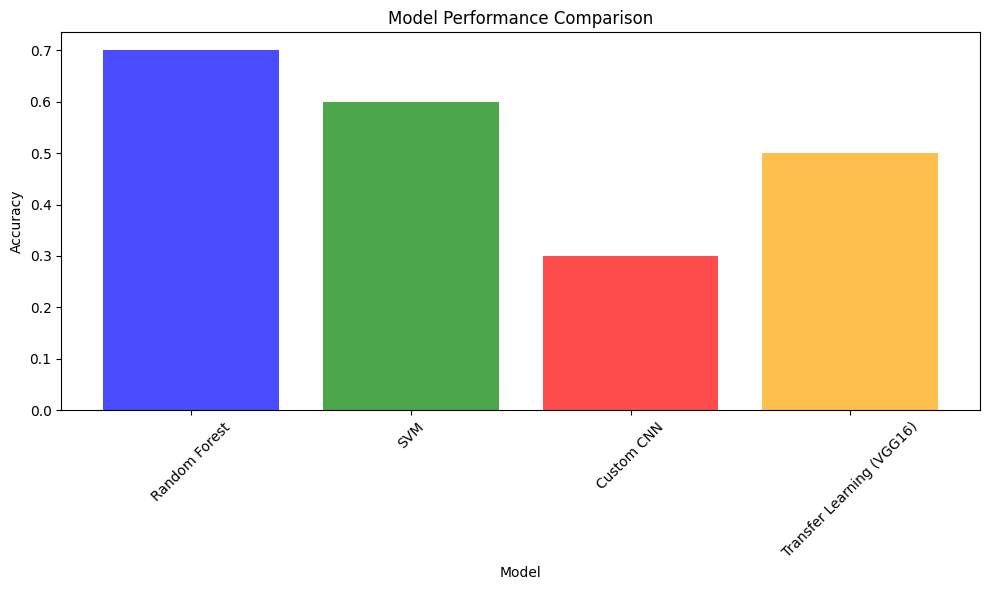

In [18]:
models_available = []
accuracies = []

if 'rf_accuracy' in locals():
    models_available.append('Random Forest')
    accuracies.append(rf_accuracy)
    
if 'svm_accuracy' in locals():
    models_available.append('SVM')
    accuracies.append(svm_accuracy)
    
if 'cnn_accuracy' in locals():
    models_available.append('Custom CNN')
    accuracies.append(cnn_accuracy)
    
if 'transfer_accuracy' in locals():
    models_available.append('Transfer Learning (VGG16)')
    accuracies.append(transfer_accuracy)

if len(models_available) > 0:
    results_df = pd.DataFrame({
        'Model': models_available,
        'Accuracy': accuracies
    })
    print(results_df)

    plt.figure(figsize=(10, 6))
    colors = ['blue', 'green', 'red', 'orange'][:len(models_available)]
    plt.bar(results_df['Model'], results_df['Accuracy'], color=colors, alpha=0.7)
    plt.title('Model Performance Comparison')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No trained models available for comparison.")


## Save Models
Save all trained models and preprocessing objects for future use.


In [19]:
import joblib

saved_models = []

if 'rf_model' in locals():
    joblib.dump(rf_model, 'random_forest_model.pkl')
    saved_models.append('Random Forest')

if 'svm_model' in locals():
    joblib.dump(svm_model, 'svm_model.pkl')
    saved_models.append('SVM')

if 'scaler' in locals():
    joblib.dump(scaler, 'scaler.pkl')
    saved_models.append('Scaler')

if 'label_encoder' in locals():
    joblib.dump(label_encoder, 'label_encoder.pkl')
    saved_models.append('Label Encoder')

if 'cnn_model' in locals():
    cnn_model.save('cnn_model.h5')
    saved_models.append('Custom CNN')

if 'transfer_model' in locals():
    transfer_model.save('transfer_model.h5')
    saved_models.append('Transfer Learning VGG16')

if saved_models:
    print(f"Saved models: {', '.join(saved_models)}")
else:
    print("No models available to save.")


Saved models: Random Forest, SVM, Scaler, Label Encoder, Custom CNN, Transfer Learning VGG16
